**Passos do Projeto:**

1. Pré-processamento de dados: Limpar e normalizar os dados. Lidar com valores ausentes, remover outliers, etc.

2. Engenharia de recursos: Criar novos recursos que possam ser informativos para o modelo.

3. Treinamento do modelo: Treina os modelos (GMM, PPCA, FA, Variational Autoencoder) com os dados das pessoas saudáveis.

4.  Detecção de anomalias: Usa o modelo treinado para identificar os não saudáveis. Aqueles que o modelo tem dificuldade em reconstruir podem ser considerados anomalias (ou seja, possíveis portadores de doenças renais crônicas).

5. Avaliação do modelo: Usa as métricas apropriadas para avaliar o desempenho do modelo. Isso pode incluir a curva ROC, a área sob a curva ROC (AUC), a precisão, o recall, o F1-score, etc.



# **Instalações e Importações**

In [ ]:
!pip install miceforest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 756.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

# https://www.kaggle.com/datasets/colearninglounge/chronic-kidney-disease?select=kidney_disease_train.csv
path_train = '/content/drive/MyDrive/kidney_disease_train.csv'
path_test = '/content/drive/MyDrive/kidney_disease_test.csv'
df = pd.read_csv(path_train)

# **Tratamento do Dados**

In [ ]:


def f(x):
  if pd.isna(x):
    return x
  else:
    nova_string = x.replace("\t","")
    if nova_string == "?": return np.nan
    else: return nova_string


df["wc"] = df["wc"].apply(f).astype(float)
df["rc"] = df["rc"].apply(f).astype(float)
df["dm"] = df["dm"].apply(f)
df["cad"] = df["cad"].apply(f)

print(df.info())
print(df["dm"].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              280 non-null    int64  
 1   age             275 non-null    float64
 2   bp              271 non-null    float64
 3   sg              244 non-null    float64
 4   al              245 non-null    float64
 5   su              242 non-null    float64
 6   rbc             173 non-null    object 
 7   pc              230 non-null    object 
 8   pcc             276 non-null    object 
 9   ba              276 non-null    object 
 10  bgr             247 non-null    float64
 11  bu              266 non-null    float64
 12  sc              268 non-null    float64
 13  sod             213 non-null    float64
 14  pot             212 non-null    float64
 15  hemo            241 non-null    float64
 16  pcv             229 non-null    float64
 17  wc              202 non-null    flo

MICE Dados Faltantes

In [ ]:
from miceforest import ImputationKernel
from miceforest import MeanMatchScheme
from miceforest import (
  mean_match_default,
  mean_match_fast_cat,
  mean_match_shap
)
df_dummy = pd.get_dummies(df)
# print(df_dummy)
# print(*df_dummy.columns)
# print(df_dummy.info())
mice_kernel = ImputationKernel(
    data = df_dummy,
    categorical_feature='auto',
    save_all_iterations = True,
    random_state = 2023
)
mice_kernel.mice(5, verbose=True)
df_input = mice_kernel.complete_data()

Initialized logger with name mice 1-5
Dataset 0
1  | age | bp | sc | bu | bgr | al | sg | su | hemo | pcv | sod | pot | wc | rc
2  | age | bp | sc | bu | bgr | al | sg | su | hemo | pcv | sod | pot | wc | rc
3  | age | bp | sc | bu | bgr | al | sg | su | hemo | pcv | sod | pot | wc | rc
4  | age | bp | sc | bu | bgr | al | sg | su | hemo | pcv | sod | pot | wc | rc
5  | age | bp | sc | bu | bgr | al | sg | su | hemo | pcv | sod | pot | wc | rc


In [ ]:
df_dummy.isna().sum()

id                        0
age                       5
bp                        9
sg                       36
al                       35
su                       38
bgr                      33
bu                       14
sc                       12
sod                      67
pot                      68
hemo                     39
pcv                      51
wc                       78
rc                       94
rbc_abnormal              0
rbc_normal                0
pc_abnormal               0
pc_normal                 0
pcc_notpresent            0
pcc_present               0
ba_notpresent             0
ba_present                0
htn_no                    0
htn_yes                   0
dm_no                     0
dm_yes                    0
cad_no                    0
cad_yes                   0
appet_good                0
appet_poor                0
pe_no                     0
pe_yes                    0
ane_no                    0
ane_yes                   0
classification_ckd  

In [ ]:
df['age'].unique()

array([62., 54., 47., 43., 42., 60., 29., 34., 48., 56., 57., 65., 80.,
       59., 50., 33., 76., 41., 49., 67., 68., 23., 52.,  8., 46., 45.,
       35., 17., 70., 71., 39., 64., 26., 72., 21., 61., 40., 58., 53.,
       28., 25., 32., 44., 24., 30., nan, 20., 75., 69., 63.,  4., 74.,
       73., 14., 37., 66., 55., 51., 83.,  2., 11., 90., 15.,  6.,  7.,
       22., 27., 12.,  3., 81., 38.])

# Normalização

In [ ]:
def min_max_normalize(df):
    df_normalized = df.copy()

    for column in df.columns:
        min_value = df[column].min()
        max_value = df[column].max()

        # Fórmula da normalização Min-Max: (x - min) / (max - min)
        df_normalized[column] = (df[column] - min_value) / (max_value - min_value)

    return df_normalized

df_input = min_max_normalize(df_input)

# **Algoritmos não Neurais**

## **GMM**

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score


# Variáveis categóricas para GMM ?

# X = df_input[ df_input["classification_notckd"] == 1 ].iloc[:,:-2].to_numpy() # Filtrando apenas saudáveis
# n_componentes = range(1,11)
# for n in n_componentes:
#     gmm = GaussianMixture(n_components=n, n_init = 5)
#     gmm.fit(X)

#     log_likelihood = gmm.score(X)

X = df_input.drop(['classification_notckd', 'classification_ckd','id'],axis=1)
y = df_input['classification_ckd']
#X_nao_saudavel = X[ y==0 ]

kf = KFold(n_splits=5, random_state=42, shuffle=True)


### Detecção de Anomalias

In [ ]:
auc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Obtém apenas os dados das pessoas saudáveis para treinar o modelo
    X_train_saudavel = X_train[y_train == 0]

    # Treina o modelo GMM
    gmm = GaussianMixture(n_components=10, random_state=42)
    gmm.fit(X_train_saudavel)

    # Usa o log da probabilidade para detecção de anomalias
    log_prob_test = gmm.score_samples(X_test)
    anomaly_score = -log_prob_test
    limiar = np.percentile(gmm.score_samples(X_train), 99)
    y_pred_test = np.where(anomaly_score < limiar, 0, 1)


   # Calcula as métricas e armazena os resultados
    auc_scores.append(roc_auc_score(y_test, anomaly_score))
    accuracy_scores.append(accuracy_score(y_test, y_pred_test))
    f1_scores.append(f1_score(y_test, y_pred_test, pos_label=0))  # A classe positiva é 0
    precision_scores.append(precision_score(y_test, y_pred_test, pos_label=0))  # A classe positiva é 0
    recall_scores.append(recall_score(y_test, y_pred_test, pos_label=0))  # A classe positiva é 0




### Métricas

In [ ]:

# Imprime as médias das métricas
print(f'Média AUC: {np.mean(auc_scores)}')
print(f'Média Accuracy: {np.mean(accuracy_scores)}')
print(f'Média F1 Score: {np.mean(f1_scores)}')
print(f'Média Precision: {np.mean(precision_scores)}')
print(f'Média Recall: {np.mean(recall_scores)}')

df_gmm = pd.DataFrame([np.mean(auc_scores), np.mean(accuracy_scores), np.mean(f1_scores), np.mean(precision_scores), np.mean(recall_scores)]).T
df_gmm.columns = ["Auc", "Accuracy","F1","Precision","Recall"]
df_gmm.index = ["GMM"]

Média AUC: 0.9986740710270123
Média Accuracy: 0.9535714285714285
Média F1 Score: 0.9392175246756528
Média Precision: 1.0
Média Recall: 0.8885055685055685


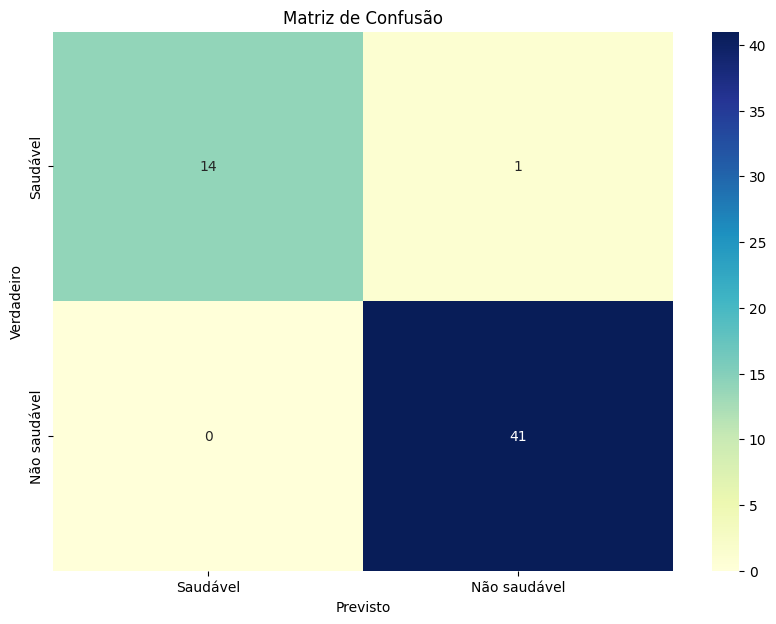

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred_test)

# Cria um DataFrame a partir da matriz de confusão para facilitar a plotagem
cm_df = pd.DataFrame(cm, index=['Saudável', 'Não saudável'], columns=['Saudável', 'Não saudável'])

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap='YlGnBu')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


## **PCA (apenas para comparação)**

### Plotar 2D

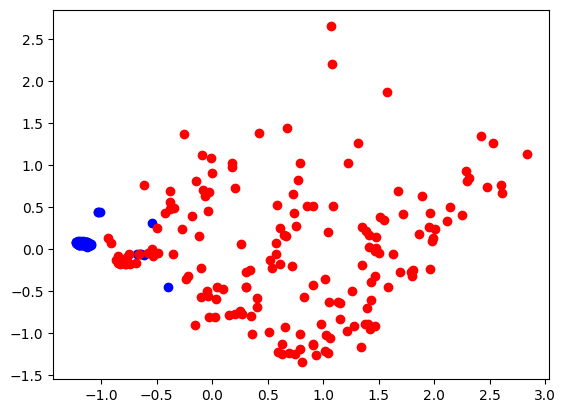

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[y == 0,0],X_pca[y == 0,1] , c= "b")
plt.scatter(X_pca[y == 1,0],X_pca[y == 1,1] , c= "r")
plt.show()

### Detecção de Anomalias

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

df_pca = pd.DataFrame(columns = ["Auc", "Accuracy","F1","Precision","Recall"])

n = 10
n_fatores_range = range(2,n+1)
print("Testar para",n,"Componentes:")
for n_fatores in n_fatores_range:
  auc_scores = []
  accuracy_scores = []
  f1_scores = []
  precision_scores = []
  recall_scores = []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_saudavel = X_train[y_train == 0]

    pca = PCA(n_components=n_fatores)
    pca.fit(X_train)

    # Erro de reconstrução treino
    X_train_pca = pca.transform(X_train)
    residuals_train = X_train - np.dot(X_train_pca, pca.components_)

    # Calcular a função de densidade
    params = {'bandwidth': np.logspace(-1, 1, 20),
              'kernel': ["gaussian", "tophat"]
              }

    grid = GridSearchCV(KernelDensity(), params, cv=5)
    grid.fit(residuals_train)
    kd = grid.best_estimator_

    anomaly_scores_train = -kd.score_samples(residuals_train)
    threshold = np.percentile(anomaly_scores_train, 99)

    # Conjunto de teste
    X_test_pca = pca.transform(X_test)
    residuals_test = X_test - np.dot(X_test_pca, pca.components_)
    anomaly_scores = -kd.score_samples(residuals_test)
    anomalies = (anomaly_scores > threshold).astype(int)

    auc_scores.append(roc_auc_score(y_test, anomaly_scores))
    accuracy_scores.append(accuracy_score(y_test, anomalies))
    f1_scores.append(f1_score(y_test, anomalies))
    precision_scores.append(precision_score(y_test, anomalies))
    recall_scores.append(recall_score(y_test, anomalies))

  auc_scores = np.array(auc_scores)
  accuracy_scores = np.array(accuracy_scores)
  f1_scores = np.array(f1_scores)
  precision_scores = np.array(precision_scores)
  recall_scores = np.array(recall_scores)

  auc = np.mean(auc_scores)
  accuracy = np.mean(accuracy_scores)
  f1 = np.mean(f1_scores)
  precision = np.mean(precision_scores)
  recall = np.mean(recall_scores)

  nova_linha = pd.DataFrame([auc, accuracy, f1, precision, recall], index = ["Auc", "Accuracy","F1","Precision","Recall"], columns = ["PCA {} Components".format(n_fatores)]).T
  df_pca = pd.concat([df_pca, nova_linha])

  print(n_fatores,"Componentes (X)")

print(df_pca)

Testar para 10 Componentes:
2 Componentes (X)
3 Componentes (X)
4 Componentes (X)
5 Componentes (X)
6 Componentes (X)
7 Componentes (X)
8 Componentes (X)
9 Componentes (X)
10 Componentes (X)
                        Auc  Accuracy        F1  Precision  Recall
PCA 2 Components   0.982288  0.946429  0.956822   0.917697     1.0
PCA 3 Components   0.986133  0.925000  0.943518   0.893887     1.0
PCA 4 Components   0.988553  0.903571  0.926482   0.870828     1.0
PCA 5 Components   0.982944  0.814286  0.867578   0.772996     1.0
PCA 6 Components   0.984248  0.778571  0.844542   0.735715     1.0
PCA 7 Components   0.983714  0.778571  0.844542   0.735715     1.0
PCA 8 Components   0.981897  0.778571  0.844542   0.735715     1.0
PCA 9 Components   0.979826  0.778571  0.844542   0.735715     1.0
PCA 10 Components  0.976583  0.778571  0.844542   0.735715     1.0


## **PPCA**

In [ ]:
class PPCA:
  def __init__(self, M, num_iter):
    self.M = M
    self.num_iter = num_iter


  def fit_transform(self, df):
    # Converte o DataFrame para um array numpy
    X = df.to_numpy()
    M = self.M
    num_iter = self.num_iter

    # Inicialização dos parâmetros
    N, D = X.shape
    mu = np.mean(X, axis=0)
    W = np.random.rand(D, M)
    sigma2 = np.random.rand()

    # Lista para armazenar a log-verossimilhança em cada iteração
    log_likelihoods = []
    # Loop do algoritmo EM
    for _ in range(num_iter):
        # Passo E
        M_inv = np.linalg.inv(np.dot(W.T, W) + sigma2 * np.eye(M))
        E_z = ( (M_inv @ W.T) @ (X - mu).T ).T
        E_zzT = sigma2 * M_inv + np.einsum('ij,ik->ijk', E_z, E_z)

        # Passo M
        W = np.dot( ((X - mu).T @ E_z), np.linalg.inv(np.sum(E_zzT, axis=0)))
        sigma2 = (np.sum(np.square(X - mu)) - 2 * np.sum(E_z * ((X - mu) @ W)) + np.trace( (E_zzT.sum(axis=0) @  (W.T @ W)) ) ) / (N * D)

        # Calcula a log-verossimilhança e a adiciona à lista
        log_likelihood = -0.5 * (D * np.log(2 * np.pi) + np.sum(np.log(sigma2) + np.trace(E_zzT, axis1=1, axis2=2) + np.dot((X - mu) @ W, E_z.T)))
        log_likelihoods.append(log_likelihood)

    # Projeção linear probabilística dos dados
    M_hat_inv = np.linalg.inv(np.dot(W.T, W) + sigma2 * np.eye(M))
    Z = np.dot(np.dot(M_hat_inv, W.T), (X - mu).T).T

    # Reconstrução probabilística das projeções
    X_hat = np.dot(Z, W.T) + mu

    self.M_hat_inv = M_hat_inv
    self.W = W
    self.sigma2 = sigma2


    return Z, X_hat, log_likelihoods

  def transform(self, X):
    X = X.to_numpy()
    mu = np.mean(X, axis = 0)
    Z = np.dot(np.dot(self.M_hat_inv, self.W.T), (X - mu).T).T
    return Z

  def reconstrucao(self, X):
    X = X.to_numpy()
    mu = np.mean(X, axis = 0)
    Z = np.dot(np.dot(self.M_hat_inv, self.W.T), (X - mu).T).T
    X_hat = np.dot(Z, self.W.T) + mu

    return X_hat

### Plotar 2D

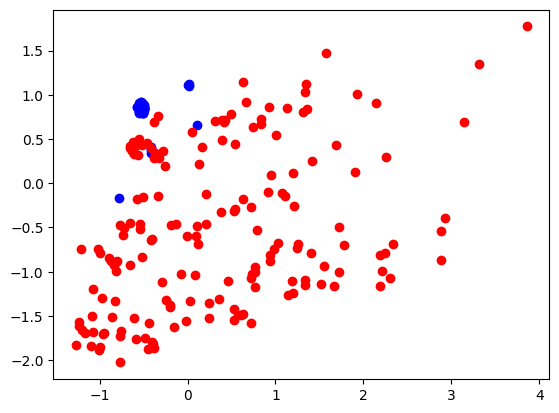

In [ ]:
ppca = PPCA(2, 100)
Z, x_hat, log_likelihoods = ppca.fit_transform(X)

plt.scatter(Z[y == 0,0],Z[y == 0,1] , c= "b")
plt.scatter(Z[y == 1,0],Z[y == 1,1] , c= "r")
plt.show()

### Detecção de Anomalias

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

df_ppca = pd.DataFrame(columns = ["Auc", "Accuracy","F1","Precision","Recall"])


n = 10
n_fatores_range = range(2,n+1)
print("Testar para",n,"Componentes:")
for n_fatores in n_fatores_range:
  auc_scores = []
  accuracy_scores = []
  f1_scores = []
  precision_scores = []
  recall_scores = []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_saudavel = X_train[y_train == 0]

    ppca = PPCA(n_fatores, 100)

    # Erro de reconstrução treino
    X_train_ppca, residuals_train, _ = ppca.fit_transform(X_train)

    # Calcular a função de densidade
    params = {'bandwidth': np.logspace(-1, 1, 20),
              'kernel': ["gaussian", "tophat"]
              }

    grid = GridSearchCV(KernelDensity(), params, cv=5)
    grid.fit(residuals_train)
    kd = grid.best_estimator_

    anomaly_scores_train = -kd.score_samples(residuals_train)
    threshold = np.percentile(anomaly_scores_train, 99)

    # Conjunto de teste
    X_test_ppca = ppca.transform(X_test)
    residuals_test = ppca.reconstrucao(X_test)
    anomaly_scores = -kd.score_samples(residuals_test)
    anomalies = (anomaly_scores > threshold).astype(int)

    auc_scores.append(roc_auc_score(y_test, anomaly_scores))
    accuracy_scores.append(accuracy_score(y_test, anomalies))
    f1_scores.append(f1_score(y_test, anomalies))
    precision_scores.append(precision_score(y_test, anomalies))
    recall_scores.append(recall_score(y_test, anomalies))

  auc_scores = np.array(auc_scores)
  accuracy_scores = np.array(accuracy_scores)
  f1_scores = np.array(f1_scores)
  precision_scores = np.array(precision_scores)
  recall_scores = np.array(recall_scores)

  auc = np.mean(auc_scores)
  accuracy = np.mean(accuracy_scores)
  f1 = np.mean(f1_scores)
  precision = np.mean(precision_scores)
  recall = np.mean(recall_scores)

  nova_linha = pd.DataFrame([auc, accuracy, f1, precision, recall], index = ["Auc", "Accuracy","F1","Precision","Recall"], columns = ["PPCA {} Components".format(n_fatores)]).T
  df_ppca = pd.concat([df_ppca, nova_linha])

  print(n_fatores,"Componentes (X)")

print(df_ppca)



Testar para 10 Componentes:
2 Componentes (X)
3 Componentes (X)
4 Componentes (X)
5 Componentes (X)
6 Componentes (X)
7 Componentes (X)
8 Componentes (X)
9 Componentes (X)
10 Componentes (X)
                         Auc  Accuracy        F1  Precision    Recall
PPCA 2 Components   0.970044  0.928571  0.935284   0.965192  0.913293
PPCA 3 Components   0.976888  0.917857  0.932115   0.957663  0.909724
PPCA 4 Components   0.981472  0.917857  0.932535   0.957095  0.910738
PPCA 5 Components   0.982589  0.910714  0.924748   0.961559  0.890738
PPCA 6 Components   0.982892  0.903571  0.919235   0.968579  0.875616
PPCA 7 Components   0.983694  0.900000  0.915468   0.968579  0.868720
PPCA 8 Components   0.982357  0.907143  0.922566   0.969412  0.881269
PPCA 9 Components   0.980890  0.892857  0.910567   0.974675  0.856878
PPCA 10 Components  0.982811  0.867857  0.886183   0.973502  0.816687


## **FA**

### Plotar 2D

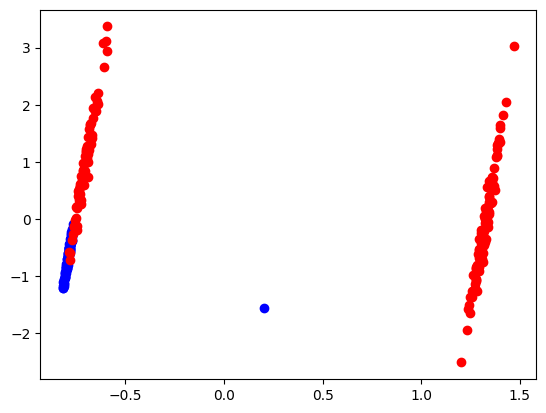

In [ ]:
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


fa = FactorAnalysis(n_components=2)
X_FA = fa.fit_transform(X)

plt.scatter(X_FA[y == 0,0],X_FA[y == 0,1] , c= "b")
plt.scatter(X_FA[y == 1,0],X_FA[y == 1,1] , c= "r")
plt.show()


### Detecção de Anomalias

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

df_fa = pd.DataFrame(columns = ["Auc", "Accuracy","F1","Precision","Recall"])


n = 10
n_fatores_range = range(2,n+1)
print("Testar para",n,"Fatores")
for n_fatores in n_fatores_range:
  auc_scores = []
  accuracy_scores = []
  f1_scores = []
  precision_scores = []
  recall_scores = []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_saudavel = X_train[y_train == 0]

    fa = FactorAnalysis(n_components=n_fatores)
    fa.fit(X_train)

    # Erro de reconstrução treino
    X_train_fa = fa.transform(X_train)
    residuals_train = X_train - np.dot(X_train_fa, fa.components_)

    # Calcular a função de densidade
    params = {'bandwidth': np.logspace(-1, 1, 20),
              'kernel': ["gaussian", "tophat"]
              }

    grid = GridSearchCV(KernelDensity(), params, cv=5)
    grid.fit(residuals_train)
    kd = grid.best_estimator_

    anomaly_scores_train = -kd.score_samples(residuals_train)
    threshold = np.percentile(anomaly_scores_train, 99)

    # Conjunto de teste
    X_test_fa = fa.transform(X_test)
    residuals_test = X_test - np.dot(X_test_fa, fa.components_)
    anomaly_scores = -kd.score_samples(residuals_test)
    anomalies = (anomaly_scores > threshold).astype(int)

    auc_scores.append(roc_auc_score(y_test, anomaly_scores))
    accuracy_scores.append(accuracy_score(y_test, anomalies))
    f1_scores.append(f1_score(y_test, anomalies))
    precision_scores.append(precision_score(y_test, anomalies))
    recall_scores.append(recall_score(y_test, anomalies))

  auc_scores = np.array(auc_scores)
  accuracy_scores = np.array(accuracy_scores)
  f1_scores = np.array(f1_scores)
  precision_scores = np.array(precision_scores)
  recall_scores = np.array(recall_scores)

  auc = np.mean(auc_scores)
  accuracy = np.mean(accuracy_scores)
  f1 = np.mean(f1_scores)
  precision = np.mean(precision_scores)
  recall = np.mean(recall_scores)

  nova_linha = pd.DataFrame([auc, accuracy, f1, precision, recall], index = ["Auc", "Accuracy","F1","Precision","Recall"], columns = ["FA {} Factors".format(n_fatores)]).T
  df_fa = pd.concat([df_fa, nova_linha])

  print(n_fatores,"Fatores (X)")


print(df_fa)



Testar para 10 Fatores
2 Fatores (X)
3 Fatores (X)
4 Fatores (X)
5 Fatores (X)
6 Fatores (X)
7 Fatores (X)
8 Fatores (X)
9 Fatores (X)
10 Fatores (X)
                    Auc  Accuracy        F1  Precision  Recall
FA 2 Factors   0.984943  0.932143  0.947391   0.902331     1.0
FA 3 Factors   0.984452  0.921429  0.937542   0.883854     1.0
FA 4 Factors   0.982801  0.885714  0.917649   0.849512     1.0
FA 5 Factors   0.981896  0.857143  0.900634   0.820250     1.0
FA 6 Factors   0.982410  0.703571  0.803749   0.677442     1.0
FA 7 Factors   0.980873  0.732143  0.818910   0.699793     1.0
FA 8 Factors   0.979057  0.750000  0.828755   0.712577     1.0
FA 9 Factors   0.977988  0.760714  0.834799   0.722216     1.0
FA 10 Factors  0.976952  0.775000  0.842744   0.732962     1.0


# **Algoritmos Neurais**

## **VAE**

### Inicialização

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# .to(torch.float32)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train = X_train[ y_train == 0 ]
y_train = y_train[ y_train == 0 ]
#train_dataset = X_train
#train_dataset["y"] = y_train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 5
train_loader = DataLoader(dataset= torch.tensor(X_train.to_numpy()).to(torch.float32) , batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset= torch.tensor(X_test.to_numpy()).to(torch.float32), batch_size=batch_size, shuffle=False)

class VAE(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def train_vae(model, optimizer, epochs, interval, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_loader):
            x = x.view(batch_size, x.shape[1]).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()
        if (epoch+1) % interval == 0 or (epoch == 0 and interval < epochs):
          print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

def verossimilhanca(model, x, device, num_samples = 20):
    model.eval()

    with torch.no_grad():
        x = x.view(1, -1).to(device)
        mean, logvar = model.encode(x)
        z = model.reparameterization(mean, logvar)

        log_likelihood = 0
        for _ in range(num_samples):
            z_sample = model.reparameterization(mean, logvar)
            x_hat = model.decode(z_sample)
            log_likelihood += -nn.functional.mse_loss(x_hat, x, reduction='sum').item()

        log_likelihood /= num_samples
        log_likelihood += -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return log_likelihood.item()

### Otimização dos Hiperparametros

In [ ]:
!pip install ax-platform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.4/582.4 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00


In [ ]:
from ax import optimize

def objective(parameterization):
    hidden_dim = parameterization.get('hidden_dim')
    latent_dim = parameterization.get('latent_dim')
    lr = parameterization.get('lr')

    model = VAE(input_dim=X.shape[1], hidden_dim=hidden_dim, latent_dim=latent_dim, device=device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss = train_vae(model, optimizer, epochs=100, interval=999, device=device)
    return loss

parameters = [
    {"name": "hidden_dim", "type": "range", "bounds": [4, 32]},
    {"name": "latent_dim", "type": "range", "bounds": [2, 16]},
    {"name": "lr", "type": "range", "bounds": [1e-5, 1e-1], "log_scale": True}
]


best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=objective,
    minimize=True,
    total_trials=15,
)

[INFO 12-03 00:44:48] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter hidden_dim. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-03 00:44:49] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter latent_dim. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-03 00:44:49] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-03 00:44:49] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='hidden_dim', parameter_type=INT, range=[4, 32]), RangeParameter(name='latent_dim', parameter_type=INT, range=[2, 16]), Rang

### Treino

In [ ]:
print(best_parameters, values, experiment, model)

input_size = X_train.shape[1]
print(X_train.shape)
hidden_size = best_parameters["hidden_dim"]
latent_size = best_parameters["latent_dim"]
lr = best_parameters["lr"]

model = VAE(input_size, hidden_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_vae(model, optimizer, epochs=500, interval = 50, device=device)

{'hidden_dim': 25, 'latent_dim': 16, 'lr': 0.0017551625919634837} ({'objective': 13.844997025289961}, {'objective': {'objective': 1.896865095493298}}) Experiment(None) <ax.modelbridge.torch.TorchModelBridge object at 0x7d36475aee00>
(87, 34)
	Epoch 1 	Average Loss:  13.191938066482544
	Epoch 50 	Average Loss:  0.2282711461186409
	Epoch 100 	Average Loss:  0.2138734981417656
	Epoch 150 	Average Loss:  0.12030581012368202
	Epoch 200 	Average Loss:  0.08476728107780218
	Epoch 250 	Average Loss:  0.07065277881920337
	Epoch 300 	Average Loss:  0.06550368554890156
	Epoch 350 	Average Loss:  0.06435861513018608
	Epoch 400 	Average Loss:  0.0646149454638362
	Epoch 450 	Average Loss:  0.06434740703552962
	Epoch 500 	Average Loss:  0.06339695975184441


5.0717567801475525

### Detecção de Anomalias

In [ ]:
auc_scores = []
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train_saudavel = X_train[y_train == 0]

  anomaly_scores_train = []
  for x in X_train_saudavel.to_numpy():
    anomaly_scores_train.append( -verossimilhanca(model, torch.tensor(x).to(torch.float32), device, num_samples = 10) )
  anomaly_scores_train = np.array(anomaly_scores_train)
  threshold = np.percentile(anomaly_scores_train, 99)

  anomaly_scores_test = []
  for x in X_test.to_numpy():
    anomaly_scores_test.append( -verossimilhanca(model, torch.tensor(x).to(torch.float32), device, num_samples = 10) )
  anomaly_scores_test = np.array(anomaly_scores_test)
  anomalies = (anomaly_scores_test > threshold).astype(int)

  auc_scores.append(roc_auc_score(y_test, anomaly_scores_test))
  accuracy_scores.append(accuracy_score(y_test, anomalies))
  f1_scores.append(f1_score(y_test, anomalies))
  precision_scores.append(precision_score(y_test, anomalies))
  recall_scores.append(recall_score(y_test, anomalies))

auc_scores = np.array(auc_scores)
accuracy_scores = np.array(accuracy_scores)
f1_scores = np.array(f1_scores)
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

auc = np.mean(auc_scores)
accuracy = np.mean(accuracy_scores)
f1 = np.mean(f1_scores)
precision = np.mean(precision_scores)
recall = np.mean(recall_scores)

df_vae = pd.DataFrame([auc, accuracy, f1, precision, recall]).T
df_vae.columns = ["Auc", "Accuracy","F1","Precision","Recall"]
df_vae.index = ["VAE"]

print(df_vae)

     Auc  Accuracy        F1  Precision  Recall
VAE  1.0  0.989286  0.990159   0.980833     1.0


NF

# Resumo dos resultados

In [ ]:
ordenar_por = "F1"

melhor_pca = df_pca.loc[df_pca[ordenar_por].idxmax()]
melhor_ppca = df_ppca.loc[df_ppca[ordenar_por].idxmax()]
melhor_fa = df_fa.loc[df_fa[ordenar_por].idxmax()]

df_comparacao_reconstrucao = pd.DataFrame()
df_comparacao_reconstrucao = df_comparacao_reconstrucao.append(melhor_pca)
df_comparacao_reconstrucao = df_comparacao_reconstrucao.append(melhor_ppca)
df_comparacao_reconstrucao = df_comparacao_reconstrucao.append(melhor_fa)
df_comparacao_reconstrucao = df_comparacao_reconstrucao.sort_values(by=ordenar_por, ascending = False)

print("Melhor quantidade de componentes para os modelos de redução de dimensionalidade")
print(df_comparacao_reconstrucao)
print()

df_comparacao_final = pd.concat([
    df_gmm,
    df_ppca,
    df_fa,
    df_vae
]).sort_values(by=ordenar_por, ascending = False)

print("Comparação entre todos os modelos testados")
print(df_comparacao_final)

Melhor quantidade de componentes para os modelos de redução de dimensionalidade
                        Auc  Accuracy        F1  Precision    Recall
PCA 2 Components   0.982288  0.946429  0.956822   0.917697  1.000000
FA 2 Factors       0.984943  0.932143  0.947391   0.902331  1.000000
PPCA 2 Components  0.970044  0.928571  0.935284   0.965192  0.913293

Comparação entre todos os modelos testados
                         Auc  Accuracy        F1  Precision    Recall
VAE                 1.000000  0.989286  0.990159   0.980833  1.000000
FA 2 Factors        0.984943  0.932143  0.947391   0.902331  1.000000
GMM                 0.998674  0.953571  0.939218   1.000000  0.888506
FA 3 Factors        0.984452  0.921429  0.937542   0.883854  1.000000
PPCA 2 Components   0.970044  0.928571  0.935284   0.965192  0.913293
PPCA 4 Components   0.981472  0.917857  0.932535   0.957095  0.910738
PPCA 3 Components   0.976888  0.917857  0.932115   0.957663  0.909724
PPCA 5 Components   0.982589  0.910714  